In [96]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy.interpolate import interp2d, RectBivariateSpline
from time import time
from random import random
from numpy import sin, cos
from math import pi

In [ ]:
## Monte Carlo simulation of photon arrival times
## Based on ANTARES collaboration paper on transmission of light in deep sea
## By comparing simulations to measured arrival times, we should be able to determine abs/scatt lengths and eta

In [2]:
## Parameters
# Absorption length
# Scattering length
# Eta fraction of molecular scattering (else particle scattering)
# Light colour
# Source-detector distance
# Collection efficiency? Angular dependence of detector? try implementing if time permits

In [4]:
## scattering angle distributions

# Input: scattering_angle (deg)
def molecular_scatt(x):
    beta = 0.06225 * (1 + 0.835 * cos(np.radians(x))*cos(np.radians(x)))
    return beta


particle_angle = np.append([0.1,
        0.12589,
        0.15849,
        0.19953,
        0.25119,
        0.31623,
        0.39811,
        0.50119,
        0.63096,
        0.79433,
        1.0000,
        1.2589,
        1.5849,
        1.9953,
        2.5119,
        3.1623,
        3.9811,
        5.0119,
        6.3096,
        7.9433], np.arange(10,185,5))

particle_phase = [1.76661e3,
                          1.29564e3,
                          9.50172e2,
                          6.99092e2,
                          5.13687e2,
                          3.76373e2,
                          2.76318e2,
                          2.18839e2,
                          1.44369e2,
                          1.02241e2,
                          7.16082e1,
                          4.95803e1,
                          3.39511e1,
                          2.28129e1,
                          1.51622e1,
                          1.00154e1,
                          6.57957,
                          4.29530,
                          2.80690,
                          1.81927,
                          1.15257,
                          4.89344e-1,
                          2.44424e-1,
                          1.47151e-1,
                          8.60848e-2,
                          5.93075e-2,
                          4.20985e-2,
                          3.06722e-2,
                          2.27533e-2,
                          1.69904e-2,
                          1.31254e-2,
                          1.04625e-2,
                          8.48826e-3,
                          6.97601e-3,
                          5.84232e-3,
                          4.95306e-3,
                          4.29232e-3,
                          3.78161e-3,
                          3.40405e-3,
                          3.11591e-3,
                          2.91222e-3,
                          2.79696e-3,
                          2.68568e-3,
                          2.57142e-3,
                          2.47603e-3,
                          2.37667e-3,
                          2.32898e-3,
                          2.31308e-3,
                          2.36475e-3,
                          2.50584e-3,
                          2.66183e-3,
                          2.83472e-3,
                          3.03046e-3,
                          3.09206e-3,
                          3.15366e-3]

# Input: scattering_angle
particle_scatt_big_ang = lambda x: np.interp(x,particle_angle,particle_phase)

# If scattering angle is < 0.12589°, use:
particle_scatt_small_ang = lambda x: 1.29564e3 * np.power(0.12589/x, 1.346)

# Input: scattering_angle (deg)
def particle_scatt(x):
    phase = []
    for ang in x:
        if ang < 0.12589:
            phase = np.append(phase,particle_scatt_small_ang(ang))
        else:
            phase = np.append(phase,particle_scatt_big_ang(ang))
    return phase




In [5]:
## Source-Detector distances
# For POCAM2; +/- 2m
sDOM1 = np.sqrt( (107.66 - 69.79)**2 + 37**2)
sDOM2 = np.sqrt( (107.66 - 49.40)**2 + 37**2)
sDOM3 = np.sqrt( (107.66 - 29.98)**2 + 37**2)
sDOM4 = np.sqrt( (107.66 - 29.96)**2 + 0)
sDOM5 = np.sqrt( (107.66 - 69.10)**2 + 0)

## group velocity of light 
c_v = .2149 # +/- .0015 m/ns, for violet light (400nm)
c_b = .2175 # +/- .0015 m/ns, for blue light (465nm)

# Input: light colour ('v'/'violet' or 'b'/'blue'), and sDOM (1-5)
# Output: group velocity of light +/- .0015 m/ns, and sDOM distance +/- 2m
def parameter_selector(colour='v', sDOM=1):
    if colour[0] == 'v':
        c = .2149 # +/- .0015 m/ns, for violet light (400nm)
    else:
        c = .2175 # +/- .0015 m/ns, for blue light (465nm)
    
    if sDOM == 1:
        sDOM_dist = np.sqrt( (107.66 - 69.79)**2 + 37**2)
    elif sDOM == 2:
        sDOM_dist = np.sqrt( (107.66 - 49.40)**2 + 37**2)
    elif sDOM == 3:
        sDOM_dist = np.sqrt( (107.66 - 29.98)**2 + 37**2)
    elif sDOM == 4:
        sDOM_dist = np.sqrt( (107.66 - 29.96)**2 + 0)
    else:
        sDOM_dist = np.sqrt( (107.66 - 69.10)**2 + 0)
        
    return (c, sDOM_dist)
        

In [6]:
## Normalized probability distributions
# For absorption, scattering length, molecular scattering angle, and particle scattering angle

# Input: scattering and absorption lengths in m
# Output: tuple of probability distributions for scattering and absorption lengths
#         and molecular and particulate scattering angles (from 0-180deg)
def probability_distributions(scatt_len, abs_len):
    
    scatt_ubound = 5 * scatt_len # after which values are negligible
    scatt_len_array = np.arange(0,scatt_ubound,.02)
    scatt_len_prob = np.exp(-scatt_len_array/scatt_len)
    scatt_len_prob = scatt_len_prob / np.sum(np.exp(-scatt_len_array/scatt_len)) # normalize sum is 1

    abs_ubound = 5 * abs_len
    abs_len_array = np.arange(0,abs_ubound,.02)
    abs_len_prob = np.exp(-abs_len_array/abs_len)
    abs_len_prob = abs_len_prob / np.sum(np.exp(-abs_len_array/abs_len)) # normalize

    m_scatt_ang_array = np.linspace(0,180,5000) # range 0-180 deg
    m_scatt_ang_prob = molecular_scatt(m_scatt_ang_array)
    m_scatt_ang_prob = m_scatt_ang_prob / np.sum(molecular_scatt(m_scatt_ang_array)) # normalize

    p_scatt_ang_array = np.linspace(0.05,180,5000) # range 0.05-180 deg (undefined at 0)
    p_scatt_ang_prob = particle_scatt(p_scatt_ang_array)
    p_scatt_ang_prob = p_scatt_ang_prob / np.sum(particle_scatt(p_scatt_ang_array)) # normalize
    
    return (scatt_len_array, scatt_len_prob, abs_len_array, abs_len_prob, 
            m_scatt_ang_array, m_scatt_ang_prob, p_scatt_ang_array, p_scatt_ang_prob)




In [7]:
## Helper functions (to deal with vectors)

# Input: [x,y,z] vector
# Output: distance from origin
def magnitude(v):
    return np.sqrt( v[0]*v[0] + v[1]*v[1] + v[2]*v[2] )

# Input: quaternions where q[0] is the scalar and q[1:] is the vector
# Output: q1*q2
def quaternion_multiply(q1,q2):
    q_scalar = q1[0]*q2[0] - np.dot(q1,q2)
    q_vector = q1[0]*q2[1:] + q2[0]*q1[1:] + np.cross(q1[1:],q2[1:])
    q = np.append(q_scalar, q_vector)
    return q

# rotation using quaternions
# Input: [x,y,z] vector v, rotation polar angle theta, azimuthal angle phi, wrt direction of v
# Output: rotated vector
def rotate(v,theta,phi):
    # First rotate by theta (note this won't work if v points along x axis)
    u1 = np.cross(v,[1,0,0])/magnitude(np.cross(v,[1,0,0])) # unit vector axis for 1st rotation
    q1 = np.append(cos(theta/2), u1*sin(theta/2)) # quaternion defining rotation by theta about u1
    q1_t = np.append(q1[0],-q1[1:]) # transpose of q1

    # rotation applied by q*(0,v)*q_t
    temp = quaternion_multiply(np.append(0,v),q1_t)
    v_rotated1 = quaternion_multiply(q1,temp)
    
    # repeat for rotation by phi
    u2 = v/magnitude(v) 
    q2 = np.append(cos(phi/2), u2*sin(phi/2))
    q2_t = np.append(q2[0],-q2[1:])
    
    temp = quaternion_multiply(v_rotated1,q2_t)
    v_rotated2 = quaternion_multiply(q2,temp)
    
    return v_rotated2[1:]




In [8]:
## Photon propagation - POCAM2

# Input: eta fraction of molecular scattering, 
#         sDOM distance, and colour of light ('v'/'violet' or 'b'/'blue')
# Output: photon arrival time (or nan if it gets absorbed)

def photon_propagation(eta,sDOM_dist,c,prob_dist):
    
    (scatt_len_array, scatt_len_prob, abs_len_array, abs_len_prob, m_scatt_ang_array, m_scatt_ang_prob,
     p_scatt_ang_array, p_scatt_ang_prob) = prob_dist
    
    # Initial conditions (origin, moving in +z direction)
    curr_pos = np.array([0, 0, 0]) # [x,y,z] in m
    direction = np.array([0,0,1]) # unit vector
    destination = np.array([0,0,sDOM_dist]) # intersection of sphere of radius sDOM-distance and line (curr_pos + direction)
    distance = 0 # total distance travelled
    flag = 0 # 0: particle still in motion; 1: particle reached detector; 2: particle absorbed

    while True:
        # Distance to scattering/absorption
        dist2scatt = np.random.choice(scatt_len_array,p=scatt_len_prob) # m
        dist2abs = np.random.choice(abs_len_array,p=abs_len_prob) # m

        # distance to detector
        dist2det = magnitude(destination - curr_pos)

        # if absorption is smallest distance, absorb photon and break
        if dist2abs < dist2scatt and dist2abs < dist2det:
            curr_pos = curr_pos + direction*dist2abs
            distance += dist2abs
            flag = 2
            break

        # if scattering is smallest distance, scatter photon and continue
        elif dist2scatt < dist2det and dist2scatt < dist2abs:
            curr_pos = curr_pos + direction*dist2scatt
            distance += dist2scatt
            scatt_type = random()
            if scatt_type < eta:
                # molecular scattering
                scatt_ang = np.random.choice(m_scatt_ang_array,p=m_scatt_ang_prob)
            else:
                # particulate scattering
                scatt_ang = np.random.choice(p_scatt_ang_array,p=p_scatt_ang_prob)
            # angles wrt direction: theta=scatt_ang and phi=2*pi*random()
            scatt_ang = np.radians(scatt_ang)
            phi = 2*pi*random()
            new_direction = rotate(direction,scatt_ang,phi)
            direction = new_direction/magnitude(new_direction) # unit vector (should already be, but just to be safe)
            # line X = curr_pos + d*direction ; intersection with sphere, at distance d
            #d = -np.dot(direction,curr_pos) + np.sqrt(np.dot(direction,curr_pos)**2 - (magnitude(curr_pos)**2 - sDOM_dist**2))
            temp = np.dot(direction,curr_pos)
            d = -temp + np.sqrt(np.power(temp,2) - (np.power(magnitude(curr_pos),2) - np.power(sDOM_dist,2)))
            destination = curr_pos + d*direction

        # else detector is smallest distance, break and record distance
        else:
            distance += dist2det
            flag = 1
            break      
    
    if flag == 1:
        # photon reached detector
        travel_time = distance/c # in ns
        direct_time = sDOM_dist/c
        residual = travel_time - direct_time
        return residual
    else:
        # photon absorbed
        return np.nan
        



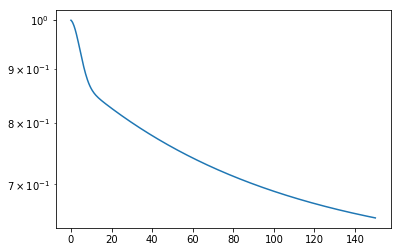

In [113]:
## Pulse-shape
# Gaussian centered at 0, width defined by full width half maximum (FWHM)
def gaussian(x,fwhm):
    a = 1/(4*np.sqrt(pi*np.log(2)))
    y = a * np.exp(-4*np.log(2)*x*x/(fwhm*fwhm))
    return y


## Curve fitting - arrival times follow a gaussian-double-exponential distribution
# Input: x values, gaussian full width half maximum, relative weight of exponential, 2 exponential time constants
# Output: gaussian+double_exponential function. Gaussian centered at x=0, with amplitude normalized to 1
def gaussian_double_exponential(x,fwhm,a,k1,k2):
    gaus = gaussian(x,fwhm)
    exp = a * np.exp( k1 * np.exp(k2*x) )
    y = (gaus+exp)/np.max(gaus+exp)
    return y

x = np.linspace(0,150,500)
y = gaussian_double_exponential(x,10,.9,.4,-.01)

fig, ax = plt.subplots()
ax.semilogy(x,y)


In [10]:
## Loop over photon propagation and plot histogram of arrival times

# Input: 
#   number of photons to simulate (100,000 photons takes ~250 seconds, with O(n) complexity, ie. grows linearly),
#   absorption and scattering lengths in m (float: 0-100), 
#   eta the fraction of molecular scattering (float: 0-1), 
#   colour of light (string: 'v'/'violet' or 'b'/'blue'),
#   sDOM number (integer: 1-5), 
#   verbosity flag; when False, suppress figures.
# Output: photon arrival times (0-150ns, 1ns uniform spacing) and save data as csv
def simulation(num_photons, abs_len, scatt_len, eta, colour, sDOM, verbose=False):

    # setup
    start = time()
    arrival_times = np.array([])
    tag = 'abs{:.1f}_scatt{:.1f}_eta{:.3f}_{}_sDOM{:d}_P2_20V_photons{:d}'.format(abs_len,scatt_len,eta,colour,sDOM,num_photons)
    path = 'Data/POSEIDON1/Simulated_arrival_times/'

    # group velocity of light +/- .0015 m/ns, and sDOM distance +/- 2m
    (c,sDOM_dist) = parameter_selector(colour,sDOM)

    # generate probability distributions (prob_dist is a tuple that contains all distributions)
    prob_dist = probability_distributions(scatt_len, abs_len)

    # propagate the photons
    for i in range(num_photons):
        residual = photon_propagation(eta,sDOM_dist,c,prob_dist)
        arrival_times = np.append(arrival_times, residual)

    # remove nans
    condition = np.invert(np.isnan(arrival_times))
    arr_time_clean = np.extract(condition,arrival_times)

    # normalize by proportion of solid angle covered by detector
    d = 3*0.0254 # PMT diameter
    area = pi*d*d/4.0 # of detector
    total_area = 4*pi*sDOM_dist*sDOM_dist # surface at source-detector radial distance
    normalization = area/total_area
    #arr_time_clean = arr_time_clean * normalization

    # execution time
    end = time()
    elapsed = end-start
    print('execution time: ' + str(elapsed) + 's')

    # Plot hist of results
    fig, ax = plt.subplots()
    (n,bins,patches) = ax.hist(arr_time_clean,bins=150,range=(0,150),log=True)
    ax.set_title(tag+ '-raw_hist')
    ax.set_xlabel('time (ns)')
    ax.set_ylabel('bincount')
    if not verbose:
        plt.close(fig)

    # gaussian pulse shape
    limit = bins[-1]
    x = np.linspace(-limit/2,limit/2,len(n)) # needs the same range and len as the histogram
    if colour[0] == 'v':
        fwhm = 10 # ns for violet
    else:
        fwhm = 8 # ns for blue
    pulse_shape = gaussian(x,fwhm)

    # convolve detector response with pulse shape
    convolved = np.convolve(pulse_shape,n, mode='same')

    # save data as csv
    file_path = path+tag+'.csv'
    with open(file_path, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(convolved)
    csvfile.close()
    
    return convolved




execution time: 2262.303292989731s
execution time: 2343.9937851428986s
execution time: 2487.9257888793945s
execution time: 2619.0620391368866s
execution time: 2727.514633178711s
execution time: 1964.1554889678955s
execution time: 2008.0664999485016s
execution time: 2058.4607062339783s
execution time: 2067.0325236320496s
execution time: 1777.3262462615967s
execution time: 1319.7370209693909s
execution time: 1510.7836952209473s
execution time: 1515.567046880722s
execution time: 1461.6745331287384s
execution time: 1492.2168810367584s
execution time: 1176.4120738506317s
execution time: 1209.050051689148s
execution time: 1215.8070619106293s
execution time: 1220.8204431533813s
execution time: 1235.1505661010742s
execution time: 1008.9639029502869s
execution time: 1028.2332842350006s
execution time: 1041.2596199512482s
execution time: 1058.076551914215s
execution time: 1081.9673609733582s
execution time: 898.8833711147308s
execution time: 916.2307548522949s
execution time: 929.6127610206604s


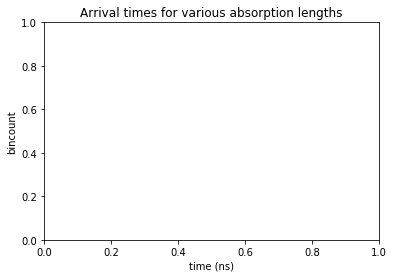

In [146]:
## Loop over parameters 

path = 'Data/POSEIDON1/Simulated_arrival_times/'

# Parameter selection
num_photons = 100000
abs_len = 50
scatt_len = 3
eta = .005
colour = 'violet'
sDOM = 1

# loop over single paramter
scatt_len_list = np.arange(2,5,.5)
#abs_len_list = np.arange(10,90,10)
eta_list = np.arange(.005,0.05,.01)

fig, ax = plt.subplots()

# store data
popt_array = np.zeros((len(eta_list),len(scatt_len_list),4))

for i in range(len(scatt_len_list)):
    scatt_len = scatt_len_list[i]
    for j in range(len(eta_list)):
        eta = eta_list[j]
        
        arr_time = simulation(num_photons, abs_len, scatt_len, eta, colour, sDOM, verbose=False)
        #ax.semilogy(arr_time, label=str(abs_len))
        arr_time = arr_time / np.max(arr_time) # normalize

        # Curve fitting to sim
        sim_data_slice = arr_time[1:-5] # remove edge effects from convolution
        x = np.arange(0,len(sim_data_slice)) # NOTE if bin size is changed this must reflect it
        p0 = [10, .002, 3, -.03] # initial parameter guess
        popt, pcov = curve_fit(gaussian_double_exponential,x,sim_data_slice,p0)
        popt_array[j,i,:] = popt[:]

np.save(path+'popt_array_(eta,scatt,popt)',popt_array)        

ax.set_title('Arrival times for various absorption lengths')
ax.set_xlabel('time (ns)')
ax.set_ylabel('bincount')
#ax.legend()

tag = 'abs10to80_scatt{:.1f}_eta{:.3f}_{}_sDOM{:d}_P2_20V_photons{:d}'.format(scatt_len,eta,colour,sDOM,num_photons)
file_path = path+tag+'.png'
#plt.savefig(file_path,bbox_inches='tight')



In [47]:
## Generate popt and chi-squared from simulation vs. data
path_sim = 'Data/POSEIDON1/Simulated_arrival_times/'
path_meas = 'Data/POSEIDON1/Measured_arrival_times/'

# Parameter selection
num_photons = 100000
abs_len = 50
scatt_len = 15
eta = .2
colour = 'violet'
sDOM = 1

# loop over single paramter
scatt_len_list = np.arange(5,70,5)
eta_list = np.arange(.05,0.35,.05)
#abs_len_list = np.arange(20,90,10)

# Get measurement data
file = "['P2'],['SDOM1'],up,violet,['20V'],['2500Hz'].csv"
my_data = np.genfromtxt(path_meas+file, delimiter=',')
times = my_data[0][:]
counts = my_data[1][:]

keep = (times>=0) & (times<=150)
times = times[keep]
counts = counts[keep]
counts = counts / np.max(counts) # normalize

#fig, ax = plt.subplots(figsize=(10,9))
#ax.semilogy(times, counts, color='k', label='meas')

# store data
popt_array = np.zeros((len(eta_list),len(scatt_len_list),4))
chi_sqr_array_actual = np.zeros((len(eta_list),len(scatt_len_list)))
chi_sqr_array_fit = np.zeros((len(eta_list),len(scatt_len_list)))

# loop over simulations to optimize parameters
for i in range(len(scatt_len_list)):
    scatt_len = scatt_len_list[i]
    for j in range(len(eta_list)):
        eta = eta_list[j]
    
        file = 'abs{:.1f}_scatt{:.1f}_eta{:.2f}_{}_sDOM{:d}_P2_20V_photons{:d}.csv'.format(abs_len,scatt_len,eta,colour,sDOM,num_photons)
        sim_data = np.genfromtxt(path_sim+file, delimiter=',')
        sim_data = sim_data / np.max(sim_data) # normalize
        #ax.semilogy(sim_data[1:], label=str(abs_len)) # plot

        # Curve fitting to sim
        sim_data_slice = sim_data[1:-5] # remove edge effects from convolution
        x = np.arange(0,len(sim_data_slice)) # NOTE if bin size is changed this must reflect it
        p0 = [10, .002, 3, -.03] # initial parameter guess
        popt, pcov = curve_fit(gaussian_double_exponential,x,sim_data_slice,p0)
        popt_array[j,i,:] = popt[:]
        
        # chi squared between sim and meas
        sim_interp = np.interp(times[1:-5],x,sim_data_slice)
        chisqr,p = chisquare(counts[1:-5],sim_interp,ddof=3)
        chi_sqr_array_actual[j,i] = chisqr
    
#tag = 'abs{:.1f}_scatt{:.1f}_eta10to30_{}_sDOM{:d}_P2_20V_photons{:d}'.format(abs_len,scatt_len,colour,sDOM,num_photons)
#tag = 'abs{:.1f}_scatt5to45_eta{:.2f}_{}_sDOM{:d}_P2_20V_photons{:d}'.format(abs_len,eta,colour,sDOM,num_photons)
tag = 'abs10to80_scatt{:.1f}_eta{:.2f}_{}_sDOM{:d}_P2_20V_photons{:d}'.format(scatt_len,eta,colour,sDOM,num_photons)

# plot meas and sim data
#ax.set_title('measured and simulated arrival times at various absorption lengths')
#ax.legend()
#ax.set_xlabel('time (ns)')
#plt.savefig('Data/POSEIDON1/Optimization/'+tag+'.png',bbox_inches='tight')

# save simulation curve fitting
#file_path = 'Data/POSEIDON1/Optimization/sim_fit_vs_abs_len_'+tag+'.csv'
#with open(file_path, 'w') as csvfile:
#    writer = csv.writer(csvfile)
#    for (sim_param,fit_params) in zip(abs_len_list,popt_array):
#        writer.writerow(np.append(sim_param,fit_params))
#csvfile.close()

    


/Users/MatthewMan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/Users/MatthewMan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


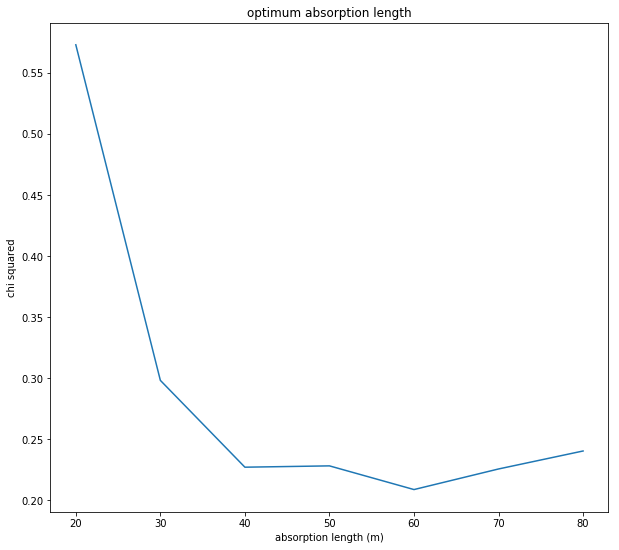

In [64]:
# Parameter selection
num_photons = 100000
abs_len = 50
scatt_len = 15
eta = .2
colour = 'violet'
sDOM = 1

# loop over single paramter
#scatt_len_list = np.arange(5,70,5)
#eta_list = np.arange(.05,0.35,.05)
abs_len_list = np.arange(20,90,10)

path_meas = 'Data/POSEIDON1/Measured_arrival_times/'
tag = "['P2'],['SDOM1'],up,violet,['20V'],['2500Hz'].png"
#tag = 'abs{:.1f}_scatt5to45_eta{:.2f}_{}_sDOM{:d}_P2_20V_photons{:d}.png'.format(abs_len,eta,colour,sDOM,num_photons)

# Get measurement data
file = "['P2'],['SDOM1'],up,violet,['20V'],['2500Hz'].csv"
my_data = np.genfromtxt(path_meas+file, delimiter=',')
times = my_data[0][:]
counts = my_data[1][:]

keep = (times>=0) & (times<=150)
times = times[keep]
counts = counts[keep]
counts = counts / np.max(counts) # normalize

chi_sqr_array = np.array([])

for abs_len in abs_len_list:
    file = 'abs{:.1f}_scatt{:.1f}_eta{:.2f}_{}_sDOM{:d}_P2_20V_photons{:d}.csv'.format(abs_len,scatt_len,eta,colour,sDOM,num_photons)
    sim_data = np.genfromtxt(path_sim+file, delimiter=',')
    sim_data = sim_data / np.max(sim_data) # normalize

    # Curve fitting to sim
    sim_data_slice = sim_data[1:-5] # remove edge effects from convolution
    x = np.arange(0,len(sim_data_slice)) # NOTE if bin size is changed this must reflect it
    p0 = [10, .002, 3, -.03] # initial parameter guess
    popt, pcov = curve_fit(gaussian_double_exponential,x,sim_data_slice,p0)
    popt_array[j,i,:] = popt[:]
        
    # chi squared between sim and meas
    sim_interp = np.interp(times[1:-5],x,sim_data_slice)
    chisqr,p = chisquare(counts[1:-5],sim_interp,ddof=3)
    chi_sqr_array = np.append(chi_sqr_array,chisqr)

#plt.plot(abs_len_list,chi_sqr_array)
fig, ax = plt.subplots(figsize=(10,9))
ax.plot(abs_len_list,chi_sqr_array)
ax.set_xlabel('absorption length (m)')
ax.set_ylabel('chi squared')
ax.set_title('optimum absorption length')
plt.savefig('Data/POSEIDON1/Optimization/abs_len_optimization.png',bbox_inches='tight')


In [ ]:
# Consider examining effect of shadow on sDOM4 (you may see direct light, but probably not)
#  because of shadow this'll probably only record scattered light. likewise for downward facing sDOMs

# If time permits, it's worth examining the effect of non-uniform angular dependence of the PMT.
#  Both angle along PMT as well as photon incidence angle. (is angle from surface normal enough? not necessarily)

# It is appropriate to increase bin width to 5ns (make sure binning is consistent between meas and sim).

# Consider adding noise to simulation

# CONSIDER randomly varying c or sDOM_dist to account for the uncertainty in both values.

# IMPORTANT: look at downward pointing sDOMs. develop simulation of this. 
#  It contains only scattered light, so should be cleaner to pinpoint scattering coefficient this way. (noisier tho)

[[ 0.36372548  3.43844346  7.76181424 12.49745133 17.10097411 20.47774171
  23.96539893 29.74206517 30.31269414 36.98932774 42.19479847 46.55336509
  46.34607148]
 [ 1.31405652  0.39900682  2.22730185  4.06258958  5.85638991  7.88895182
  10.68859597 12.30558967 14.276639   16.99596557 19.60442467 21.47211247
  22.87247051]
 [ 4.53950715  0.31015175  0.48176119  1.41306209  2.72850146  4.1689093
   5.64577582  6.78821035  8.6585964   9.85476795 10.87965814 12.73428234
  13.50019502]
 [ 9.05773209  1.1890589   0.22831918  0.55945101  1.22759955  2.2978702
   3.0653978   3.87627717  5.20178241  6.23689404  7.50850026  8.02055
   9.21258592]
 [14.24028136  2.4569692   0.51065312  0.2478089   0.50847975  1.09392506
   1.83869515  2.47045003  3.36838479  4.65012987  4.8581405   5.60302793
   6.28629384]
 [20.81705726  4.28234958  1.05993122  0.27951911  0.28675169  0.56903886
   0.95030902  1.66890873  2.29594969  2.949564    3.75857908  4.30829085
   4.846541  ]]


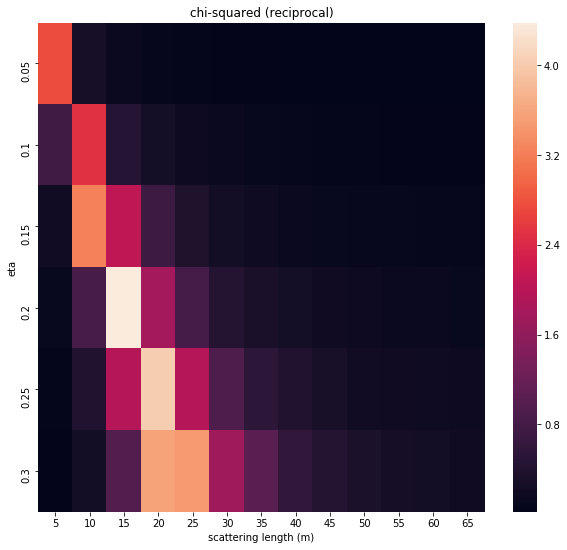

In [61]:
# plot chi-squared
# as function of scatt_len and eta

scatt_len_list = np.arange(5,70,5)
eta_list = np.array([.05,.1,.15,.2,.25,.3]) #np.arange(.05,0.35,.05)

chi_sqr_inverse = 1/chi_sqr_array_actual
print(chi_sqr_array_actual)

fig, ax = plt.subplots(figsize=(10,9))
sns.heatmap(chi_sqr_inverse,ax=ax,yticklabels=eta_list, xticklabels=scatt_len_list)
ax.set_xlabel('scattering length (m)')
ax.set_ylabel('eta')
ax.set_title('chi-squared (reciprocal)')
plt.savefig('Data/POSEIDON1/Optimization/chi_squared_scatt5to65_eta5to30.png',bbox_inches='tight')




20 0.16185916213823584
25 0.15331913162778585
30 0.16693394617135032
35 0.17850782063780285
40 0.19351596564268353
45 0.2117634202659976
50 0.23435400509753715
55 0.22378262265966137
60 0.21383033732629206


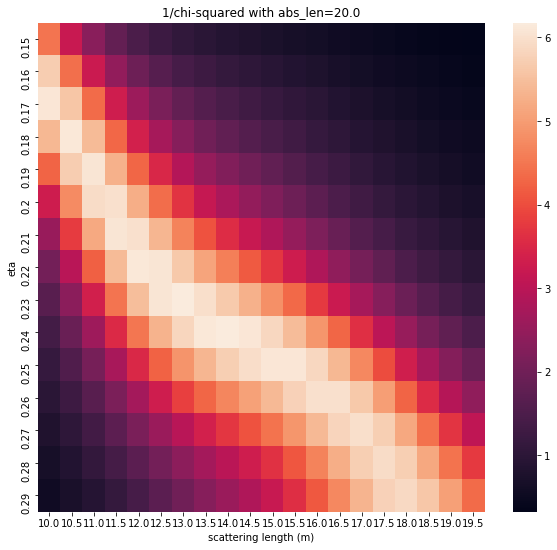

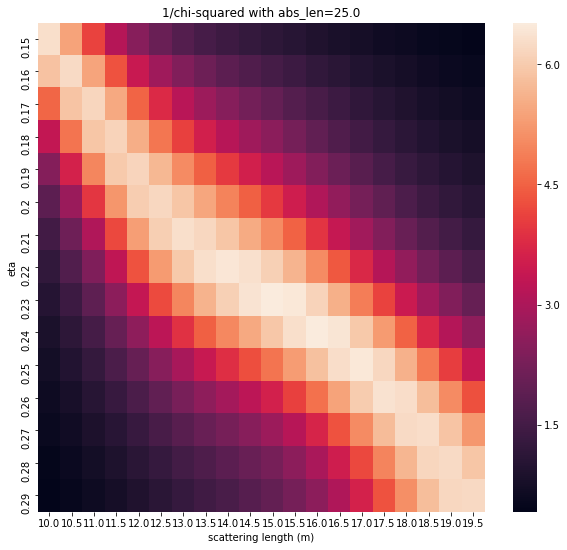

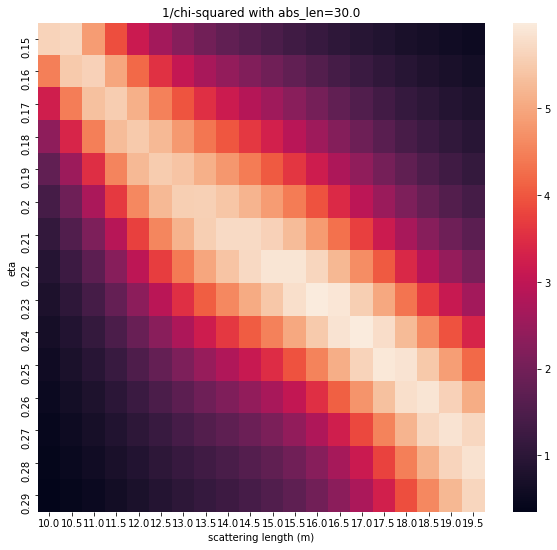

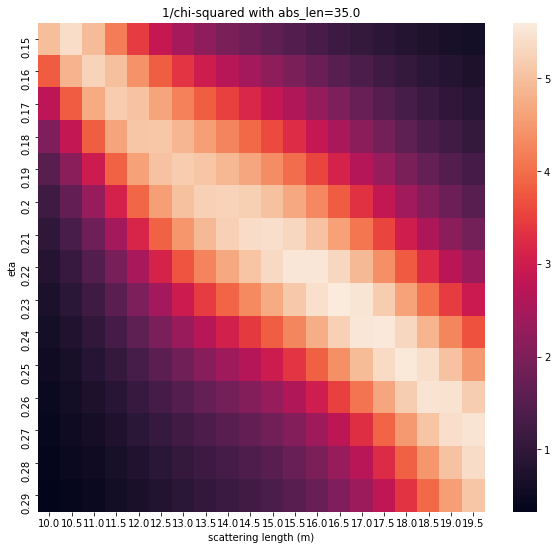

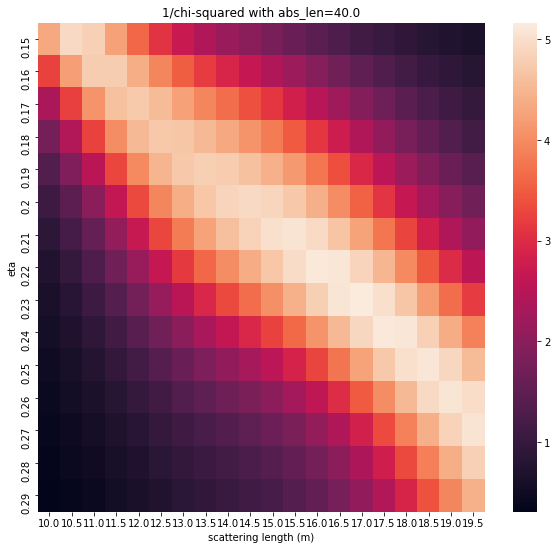

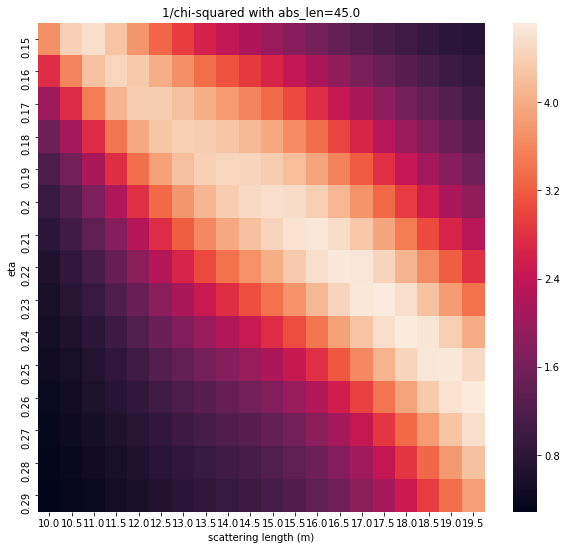

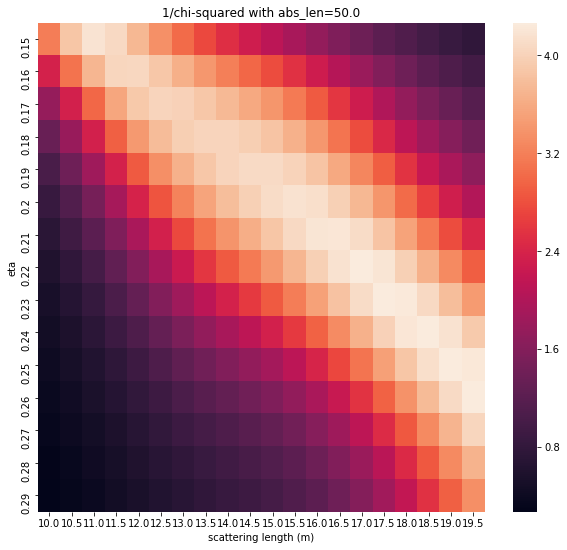

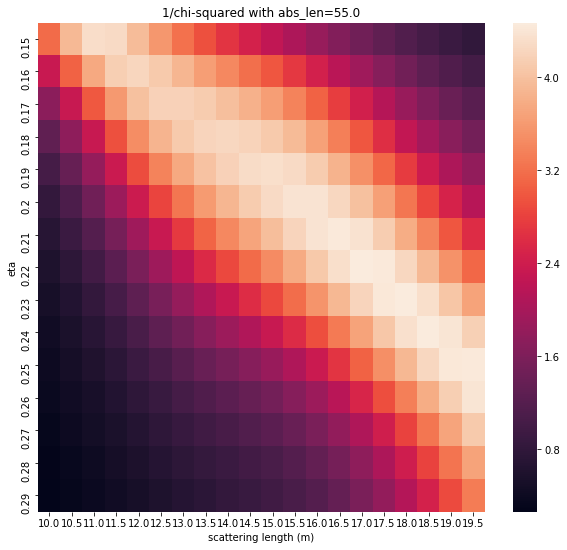

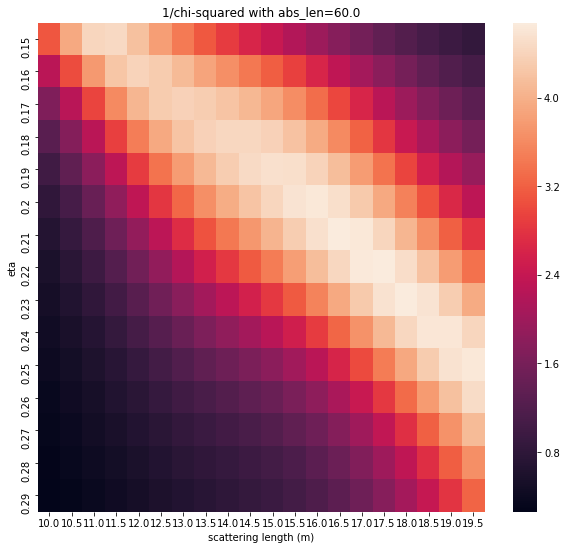

In [127]:
## Minimize chi_squared over all variables (abs,scatt,eta)
#popt_array = np.load('Data/POSEIDON1/Simulated_arrival_times/popt_array_(eta,scatt,popt).npy')
#print(popt_array)

scatt_len_list = np.arange(5,70,5)
eta_list = np.arange(.05,0.35,.05)

# read fit params over abs_len from csv
file= 'sim_fit_vs_abs_len_abs10to80_scatt15.0_eta0.20_violet_sDOM1_P2_20V_photons100000.csv'
abs_len_fit_params = np.genfromtxt('Data/POSEIDON1/Optimization/'+file, delimiter=',')
abs_len_list = abs_len_fit_params[:,0]
a_vs_abs_len = abs_len_fit_params[:,2]
k1_vs_abs_len = abs_len_fit_params[:,3]
k2_vs_abs_len = abs_len_fit_params[:,4]

eta_list_fine = np.array([0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25,
       0.26, 0.27, 0.28, 0.29]) #np.arange(.15,.3,.01)
scatt_len_list_fine = np.arange(10,20,.5)
abs_len_list_fine = np.arange(20,65,5)

# Get measurement data
path_meas = 'Data/POSEIDON1/Measured_arrival_times/'
file = "['P2'],['SDOM1'],up,violet,['20V'],['2500Hz'].csv"
my_data = np.genfromtxt(path_meas+file, delimiter=',')
times = my_data[0][:]
counts = my_data[1][:]
keep = (times>=0) & (times<=150)
times = times[keep]
counts = counts[keep]
counts = counts / np.max(counts) # normalize

a_array = popt_array[:,:,1]
k1_array = popt_array[:,:,2]
k2_array = popt_array[:,:,3]

f_a = RectBivariateSpline(eta_list,scatt_len_list,a_array)
f_k1 = RectBivariateSpline(eta_list,scatt_len_list,k1_array)
f_k2 = RectBivariateSpline(eta_list,scatt_len_list,k2_array)

for abs_len in abs_len_list_fine:

    chi_sqr_array_fit = np.zeros((len(eta_list_fine),len(scatt_len_list_fine)))
    
    # get scaling factors for fit params based on deviation of abs_len from 50m
    a_scaling = np.interp(abs_len,abs_len_list,a_vs_abs_len)/a_vs_abs_len[3]
    k1_scaling = np.interp(abs_len,abs_len_list,k1_vs_abs_len)/k1_vs_abs_len[3]
    k2_scaling = np.interp(abs_len,abs_len_list,k2_vs_abs_len)/k2_vs_abs_len[3]

    # loop over simulations to optimize parameters
    for i in range(len(scatt_len_list_fine)):
        scatt_len = scatt_len_list_fine[i]
        for j in range(len(eta_list_fine)):
            eta = eta_list_fine[j]

            a = f_a(eta,scatt_len)[0,0] * a_scaling
            k1 = f_k1(eta,scatt_len)[0,0] * k1_scaling
            k2 = f_k2(eta,scatt_len)[0,0] * k2_scaling
            curve_fit = gaussian_double_exponential(times,10,a,k1,k2)

            # chi squared between sim and meas
            chisqr,p = chisquare(counts,curve_fit,ddof=3)
            chi_sqr_array_fit[j,i] = chisqr
    
    print(abs_len, np.min(chi_sqr_array_fit))
    chi_sqr_inverse = 1/chi_sqr_array_fit
    
    fig, ax = plt.subplots(figsize=(10,9))
    sns.heatmap(chi_sqr_inverse,ax=ax,yticklabels=eta_list_fine, xticklabels=scatt_len_list_fine)
    ax.set_xlabel('scattering length (m)')
    ax.set_ylabel('eta')
    ax.set_title('1/chi-squared with abs_len=%2.1f'%abs_len)
    #plt.savefig('Data/POSEIDON1/Optimization/chi_squared_fine_abs%2.1f.png'%abs_len,bbox_inches='tight')
